In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Once data has finished processing, load data from folder structure
# text-data/
# ├─ advertisement/
# ├─ email/
# ├─ invoice/
# ....
data = load_files('../text-data', encoding='utf-8', decode_error='ignore')

X = data.data               
y = data.target             
class_names = data.target_names 

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# vectorize text using TF-IDF
vectorizer = TfidfVectorizer(
    # this is all first pass so might want to update after check in
    # limit vocab
    max_features=5000,
    # ignore terms that appear in fewer than 2 documents     
    min_df=2,               
    # ignore terms that appear in more than 80% of documents
    max_df=0.8,
    # using unigrams and bigrams             
    ngram_range=(1, 2), 
    # removing common English words    
    stop_words='english'
)

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [3]:
# train baseline Logistic Regression
base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train_vectors, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [4]:
# eval on test set
y_pred = base_model.predict(X_test_vectors)
print(f"Test Accuracy: {base_model.score(X_test_vectors, y_test)}\n")

print("Baseline Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test Accuracy: 0.7441077441077442

Baseline Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.79      0.74      0.76        68
                budget       0.76      0.85      0.81        75
                 email       0.94      0.91      0.93        56
           file_folder       0.49      0.88      0.63        56
                  form       0.76      0.62      0.68        63
           handwritten       0.80      0.62      0.70        79
               invoice       0.84      0.78      0.81        54
                letter       0.60      0.55      0.57        53
                  memo       0.75      0.74      0.74        57
          news_article       0.74      0.74      0.74        65
          presentation       0.57      0.58      0.57        64
         questionnaire       0.82      0.81      0.82        58
                resume       0.97      0.92      0.95        66
scientific_publication       0.73   

c:\Users\snake\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\snake\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\snake\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [5]:
# tuning with grid search

# chains vectorizer and model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    # max vocab size
    'tfidf__max_features': [3000, 5000, 7000],
    # unigrams only, unigrams + bigrams, unigrams + bigrams + trigrams
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    # min document frequency - removes rare words
    'tfidf__min_df': [2, 3, 5],
    # max document frequency - removes common words
    'tfidf__max_df': [0.7, 0.8, 0.9],
    # inverse regularization strength
    'clf__C': [0.1, 1, 10],
    # optimization algo
    'clf__solver': ['liblinear', 'lbfgs'],
    # L2 regularization
    'clf__penalty': ['l2']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'clf__penalty': ['l2'], 'clf__solver': ['liblinear', 'lbfgs'], 'tfidf__max_df': [0.7, 0.8, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [6]:
# evaluate tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print(f"Tuned Test Accuracy: {best_model.score(X_test, y_test)}")

print("Tuned Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=class_names))

Tuned Test Accuracy: 0.7631874298540965
Tuned Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.84      0.75      0.79        68
                budget       0.80      0.84      0.82        75
                 email       0.94      0.91      0.93        56
           file_folder       0.52      0.80      0.63        56
                  form       0.73      0.63      0.68        63
           handwritten       0.80      0.70      0.74        79
               invoice       0.84      0.78      0.81        54
                letter       0.67      0.64      0.65        53
                  memo       0.81      0.75      0.78        57
          news_article       0.73      0.72      0.73        65
          presentation       0.59      0.61      0.60        64
         questionnaire       0.84      0.90      0.87        58
                resume       0.93      0.94      0.93        66
scientific_publication       0.76 

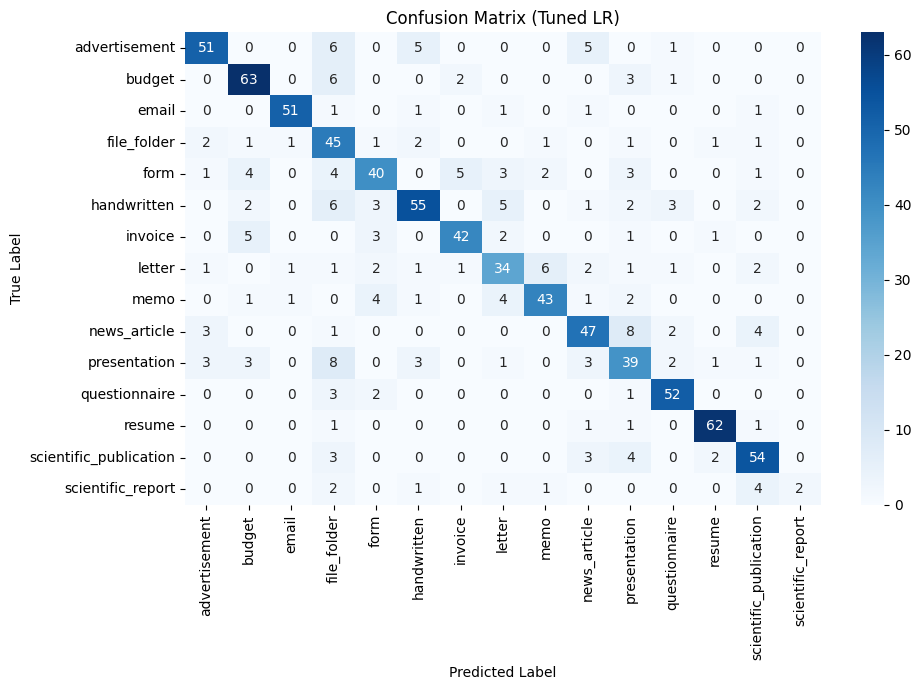

<Figure size 640x480 with 0 Axes>

In [7]:
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix (Tuned LR)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

plt.savefig('confusion_matrix_tuned_lr.png')

In [8]:
# feature analysis
tuned_vectorizer = best_model.named_steps['tfidf']
tuned_clf = best_model.named_steps['clf']
feature_names = np.array(tuned_vectorizer.get_feature_names_out())

top_n = 10
for i, class_label in enumerate(class_names):
    # get and print top weights and features
    coefficient = tuned_clf.coef_[i]
    top_indices = np.argsort(coefficient)[-top_n:]
    top_features = feature_names[top_indices]
    top_weights = coefficient[top_indices]
    print(f"Top features for class '{class_label}':")
    for feature, weight in zip(top_features, top_weights):
        print(f"{feature}: {weight:.4f}")

Top features for class 'advertisement':
marlboro: 2.9873
web: 2.9912
mg: 3.3360
pleasure: 3.3764
come: 3.6615
taste: 3.8564
advertisement: 4.0537
music: 4.1504
camels: 4.5047
Top features for class 'budget':
project: 2.9661
media: 3.2739
kool: 3.3962
institute: 3.3967
march: 3.4889
tobacco institute: 4.0861
000: 4.6699
budget: 4.7409
00: 5.6787
total: 6.9410
Top features for class 'email':
bravo: 3.0982
karen: 3.1615
2000: 3.4204
message: 3.8086
joanne: 3.8168
cc: 3.8629
original message: 4.3988
pm: 5.5260
sent: 6.9206
subject: 9.3884
Top features for class 'file_folder':
file: 1.8404
inbifo: 1.8515
presentations: 1.8896
207: 1.8907
ets: 1.9400
ctr: 2.1046
ph: 2.1414
boy: 2.2120
005: 2.2837
correspondence: 3.0302
Top features for class 'form':
description: 3.1681
code: 3.2246
guidelines: 3.2826
zn: 3.3251
sheet: 3.4795
form: 3.5486
facsimile: 3.5615
datum: 4.0693
fax: 5.7293
date: 7.7448
Top features for class 'handwritten':
mailing list: 3.0470
pa: 3.1355
salem: 3.4002
st: 3.6704
dear

In [9]:
# save model
import joblib
joblib.dump(best_model, 'lr_tuned.pkl')

['lr_tuned.pkl']